<a href="https://colab.research.google.com/github/pareshrchaudhary/qlearningtrajectory/blob/main/QLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports


In [1]:
!git clone https://github.com/pareshrchaudhary/qlearningtrajectory.git

Cloning into 'qlearningtrajectory'...
remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 14 (delta 2), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (14/14), 1.35 MiB | 7.39 MiB/s, done.


In [6]:
pip install imageio

In [7]:
import sys
import numpy as np
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import random
import matplotlib.pyplot as plt
from IPython.display import Image, display
import imageio

sys.path.append("/content/qlearningtrajectory")
from trajectorylearning import dynamics, dqn, replay

#Target Trajectory

torch.Size([65, 3])


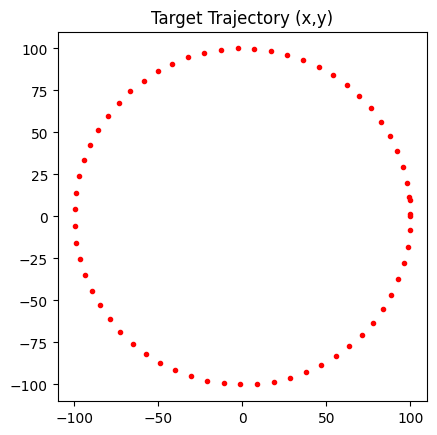

In [9]:
NTRAJSTEPS = 65 # no gap for dt = 0.1
dt = 0.1

target = torch.zeros((NTRAJSTEPS, 3))
targtrajarray = torch.arange(0.0, NTRAJSTEPS*dt, dt)

# Circle: compute positions
x = 100 * torch.cos(targtrajarray)
y = 100 * torch.sin(targtrajarray)

# Compute headings from positions
prevpos = torch.stack((x[:-2], y[:-2]), dim=1)
nextpos = torch.stack((x[2:], y[2:]), dim=1)
heading = nextpos - prevpos
theta = torch.atan2(heading[:, 1], heading[:, 0])

# Add heading for first and last position
theta = torch.cat((torch.tensor([torch.atan2(y[1] - y[0], x[1] - x[0])]), theta, torch.tensor([torch.atan2(y[-1] - y[-2], x[-1] - x[-2])])))

target = torch.cat((x.unsqueeze(1), y.unsqueeze(1), theta.unsqueeze(1)), dim=1)
print(target.shape)
plt.figure()
plt.plot(target[:, 0], target[:, 1], 'r.')
plt.axis('square')
plt.title('Target Trajectory (x,y)')
plt.show()

In [10]:
test = replay.ReplayBuffer(buffer_size=1000)

for i in range(0, 32):
  state = torch.tensor([1.0, 2.0, 0.5])  # Example state
  action =  torch.tensor([0.1909, -0.0496])  # Example action
  reward = 0.1  # Example reward
  next_state = torch.tensor([1.2, 2.1, 0.6])  # Example next state
  done = False  # Example done flag
  test.add_experience(state, action, reward, next_state, done)

batch_size = 32
batch = test.sample_batch(batch_size)
print(len(test))
print(batch)
# states, actions, rewards, next_states, dones = buffer.sample_batch(batch_size)

32
((tensor([1.0000, 2.0000, 0.5000]), tensor([1.0000, 2.0000, 0.5000]), tensor([1.0000, 2.0000, 0.5000]), tensor([1.0000, 2.0000, 0.5000]), tensor([1.0000, 2.0000, 0.5000]), tensor([1.0000, 2.0000, 0.5000]), tensor([1.0000, 2.0000, 0.5000]), tensor([1.0000, 2.0000, 0.5000]), tensor([1.0000, 2.0000, 0.5000]), tensor([1.0000, 2.0000, 0.5000]), tensor([1.0000, 2.0000, 0.5000]), tensor([1.0000, 2.0000, 0.5000]), tensor([1.0000, 2.0000, 0.5000]), tensor([1.0000, 2.0000, 0.5000]), tensor([1.0000, 2.0000, 0.5000]), tensor([1.0000, 2.0000, 0.5000]), tensor([1.0000, 2.0000, 0.5000]), tensor([1.0000, 2.0000, 0.5000]), tensor([1.0000, 2.0000, 0.5000]), tensor([1.0000, 2.0000, 0.5000]), tensor([1.0000, 2.0000, 0.5000]), tensor([1.0000, 2.0000, 0.5000]), tensor([1.0000, 2.0000, 0.5000]), tensor([1.0000, 2.0000, 0.5000]), tensor([1.0000, 2.0000, 0.5000]), tensor([1.0000, 2.0000, 0.5000]), tensor([1.0000, 2.0000, 0.5000]), tensor([1.0000, 2.0000, 0.5000]), tensor([1.0000, 2.0000, 0.5000]), tensor([1

# Q Learning Functions

In [11]:
# Q Learning Functions
def choose_action(state, q_net, epsilon):
    if torch.rand(()) < epsilon: # Explore (choose a random action)
        action = torch.randn(2)
        action = np.clip(action, 0.0, 1.0)
    else:
      with torch.no_grad():      # Exploit (choose the action with the maximum Q-value)
        q_values = q_values = q_net(state.clone().detach().requires_grad_(True))
        index = torch.argmin(q_values)
        action = q_values.clone().detach()
        action[index] = 0.0
        action = np.clip(action, 0.0, 1.0)
    return action

In [12]:
state = torch.tensor([1.0, 2.0, 0.5])
state_dim = 3
action_dim = 2
dqn_test = dqn.DQN(state_dim, action_dim)

choose_action(state, dqn_test, 0.95)

tensor([0.0000, 0.2888])

#Training

In [13]:
# Environment parameters
dt = 0.02
rad2deg = 180.0 / np.pi
deg2rad = np.pi / 180.0
env = dynamics.CarEnvironment(dt)
initial_state = torch.tensor([100.0, 0.0, 90.0 * deg2rad])
Target = target

# Q-Network
state_dim = 3
action_dim = 2
dqn_primary = dqn.DQN(state_dim, action_dim)
dqn_primary.initialize_weights()
target_network = dqn.DQN(state_dim, action_dim)
target_network.load_state_dict(dqn_primary.state_dict())
target_network.eval()
optimizer = torch.optim.Adam(dqn_primary.parameters(), lr=0.001)

# Experience Replay - Buffer
buffer_size = 10000
batch_size = 325
replay_buffer = replay.ReplayBuffer(buffer_size)

# Training Loop Parameters
num_episodes = 50
drivestep = 325

learning_rate = 0.001
epsilon = 1.0  # Initial exploration rate
epsilon_decay = 0.995  # Decay rate of exploration rate
epsilon_min = 0.01  # Minimum exploration rate
gamma = 0.99  # Discount factor

In [14]:
for episode in range(0,num_episodes):
  state = initial_state
  total_reward = 0
  target_update_interval = 100
  for t in range(0,drivestep):
    action = choose_action(state, dqn_primary, epsilon)
    next_state, reward, done = env.step(state, action, Target.clone())
    # print("State: ", state, "Action: ", action,"Reward: ", reward, "Next State: ", next_state, "Done: ", done)
    replay_buffer.add_experience(state, action, reward, next_state, done)

    if len(replay_buffer) >= batch_size:
      # mini_batch of experiences
      states, actions, rewards, next_states, dones = replay_buffer.sample_batch(batch_size)
      # Convert the lists to PyTorch tensors
      states = torch.stack(states)
      actions = torch.stack(actions)
      rewards = torch.tensor(rewards, dtype=torch.float32)
      next_states = torch.stack(next_states)
      dones = torch.tensor(dones, dtype=torch.bool)
      # print("\nStates: ", states, "\nActions: ", actions,"\nRewards: ", rewards, "\nNext States: ", next_states, "\nDones: ", dones)

      # Compute target Q-values
      with torch.no_grad():
          target_q_values = target_network(next_states)
          max_indices = torch.argmax(target_q_values, dim=1)
          target_q_values = torch.max(target_q_values, dim=1)[0]  # Take the maximum Q-value for each next state
          # print("target_q_values = ", target_q_values, target_q_values.shape)
          target_q_values[dones] = 0  # Set target Q-values to 0 for terminal states
          target_q_values = rewards + gamma * target_q_values
          # print("target_q_values = ", target_q_values, target_q_values.shape)


      # Compute current Q-values
      predicted_q_values = dqn_primary(states)
      # Convert the actions tensor to long data type
      predicted_q_values = torch.gather(predicted_q_values, 1, max_indices.unsqueeze(1)).squeeze(1)
      # print("predicted_q_values = ", predicted_q_values, predicted_q_values.shape)

      # Compute the loss function
      loss = F.smooth_l1_loss(predicted_q_values, target_q_values)

      # Perform Optimization
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      print("Loss:", loss.item())

      total_reward += reward

    # Update the current state
    state = Target[t%65]

    # Update the target network periodically
    if t % target_update_interval == 0:
        target_network.load_state_dict(dqn_primary.state_dict())

    # Update exploration parameter
    print(f"Episode: {episode + 1}, Step: {t + 1}, Total Reward: {total_reward}, Epsilon: {epsilon:.4f}")
    epsilon = max(epsilon * epsilon_decay, epsilon_min)

    # Check if the episode is done
    if done:
        break


Streaming output truncated to the last 5000 lines.
Loss: 0.012984294444322586
Episode: 93, Step: 101, Total Reward: 97.0, Epsilon: 0.0100
Loss: 0.005392735358327627
Episode: 93, Step: 102, Total Reward: 98.0, Epsilon: 0.0100
Loss: 0.060035694390535355
Episode: 93, Step: 103, Total Reward: 99.0, Epsilon: 0.0100
Loss: 0.0215243361890316
Episode: 93, Step: 104, Total Reward: 100.0, Epsilon: 0.0100
Loss: 0.07201807200908661
Episode: 93, Step: 105, Total Reward: 101.0, Epsilon: 0.0100
Loss: 0.05297331139445305
Episode: 93, Step: 106, Total Reward: 102.0, Epsilon: 0.0100
Loss: 0.18706803023815155
Episode: 93, Step: 107, Total Reward: 103.0, Epsilon: 0.0100
Loss: 0.13176117837429047
Episode: 93, Step: 108, Total Reward: 104.0, Epsilon: 0.0100
Loss: 0.05149529501795769
Episode: 93, Step: 109, Total Reward: 105.0, Epsilon: 0.0100
Loss: 0.08031822741031647
Episode: 93, Step: 110, Total Reward: 106.0, Epsilon: 0.0100
Loss: 0.0666724368929863
Episode: 93, Step: 111, Total Reward: 107.0, Epsilon: 0

#Test

<ipython-input-16-7672c1aee0e1>:73: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = [imageio.imread(path) for path in image_paths]


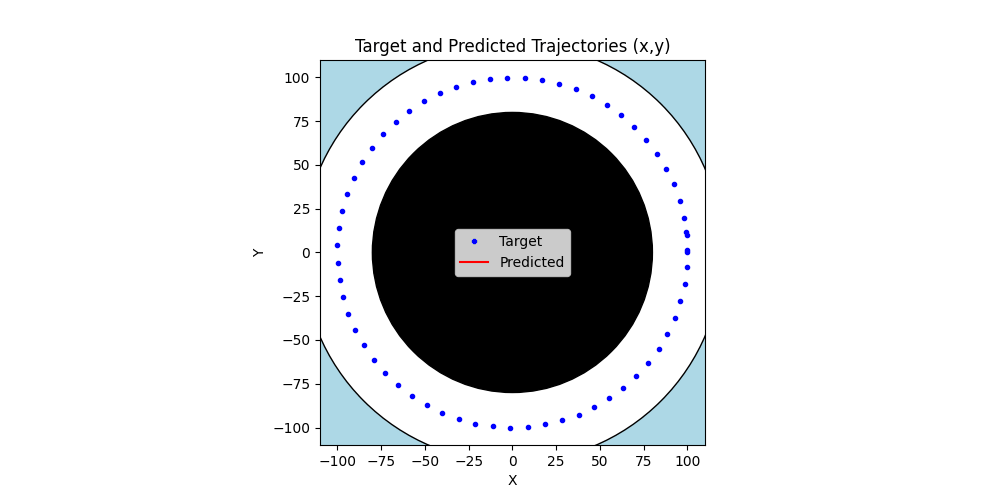

In [16]:
NTRAJSTEPS = 65
dt = 0.1

target = torch.zeros((NTRAJSTEPS, 3))
targtrajarray = torch.arange(0.0, NTRAJSTEPS * dt, dt)

# Circle: compute positions
x = 100 * torch.cos(targtrajarray)
y = 100 * torch.sin(targtrajarray)

# Compute headings from positions
prevpos = torch.stack((x[:-2], y[:-2]), dim=1)
nextpos = torch.stack((x[2:], y[2:]), dim=1)
heading = nextpos - prevpos
theta = torch.atan2(heading[:, 1], heading[:, 0])

# Add heading for first and last position
theta = torch.cat((torch.tensor([torch.atan2(y[1] - y[0], x[1] - x[0])]), theta, torch.tensor([torch.atan2(y[-1] - y[-2], x[-1] - x[-2])])))

target = torch.cat((x.unsqueeze(1), y.unsqueeze(1), theta.unsqueeze(1)), dim=1)

# Initialize the current state
state = initial_state

# Generate predicted trajectory
predicted_trajectory = []
for t in range(NTRAJSTEPS):
    # Choose an action based on the current state
    action = dqn_primary(state).detach()
    # print("Action = ", action)
    # Take a step in the environment
    Predicted_State, reward, done  = env.step(state, action, target)
    # print("Predicted_State = ", Predicted_State)
    # Add the state to the predicted trajectory
    predicted_trajectory.append(state)

    # Update the current state
    state = target[t]

# Convert the predicted trajectory to a tensor
predicted_trajectory = torch.stack(predicted_trajectory)


# Create the GIF animation
image_paths = []
for t in range(NTRAJSTEPS):
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    ax.set_facecolor('lightblue')
    ax.set_aspect(1)

    outer_circle = plt.Circle((0.0, 0.0), 120, facecolor='White', edgecolor='black')
    inner_circle = plt.Circle((0.0, 0.0), 80, facecolor='black', edgecolor='black')

    ax.add_artist(outer_circle)
    ax.add_artist(inner_circle)

    ax.plot(target[:, 0], target[:, 1], 'b.', label='Target')
    ax.plot(predicted_trajectory[:t, 0], predicted_trajectory[:t, 1], 'r', label='Predicted')
    ax.axis('square')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('Target and Predicted Trajectories (x,y)')
    ax.legend()

    # Save the plot as an image
    image_path = f"plot_{t}.png"
    plt.savefig(image_path)
    image_paths.append(image_path)
    plt.close(fig)

# Create a GIF from the saved plot images
gif_path = "output.gif"
images = [imageio.imread(path) for path in image_paths]
imageio.mimsave(gif_path, images, duration=0.3)  # Adjust duration as needed

# Display the GIF
display(Image(filename=gif_path))